## 🔗 Table of Contents <a id="🔗-table-of-contents"></a>

- [Midprices of all Products Round 3 2025](#midprices-of-all-products-round-3-2025)
- [Correlation Products 2025](#correlation-products-2025)
- [VOLCANIC products only](#volcanic-products-only)
- [Plotting intrinsic values + mid prices Day 0, Day 1, Day 2](#plotting-intrinsic-values-+-mid-prices-day-0,-day-1,-day-2)
- [Correlations 2023 (round4), 2025](#correlations-2023-(round4),-2025)
- [Correlations 2024 (round3), 2025](#correlations-2024-(round3),-2025)
- [Black-Scholes Formula](#black-scholes-formula)

### Helper functions

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

voucher_names = [
        "VOLCANIC_ROCK_VOUCHER_9500",
        "VOLCANIC_ROCK_VOUCHER_9750",
        "VOLCANIC_ROCK_VOUCHER_10000",
        "VOLCANIC_ROCK_VOUCHER_10250",
        "VOLCANIC_ROCK_VOUCHER_10500",
    ]

volcanic_products = [ 
    'VOLCANIC_ROCK',
    'VOLCANIC_ROCK_VOUCHER_9500',
    'VOLCANIC_ROCK_VOUCHER_9750',
    'VOLCANIC_ROCK_VOUCHER_10000',
    'VOLCANIC_ROCK_VOUCHER_10250',
    'VOLCANIC_ROCK_VOUCHER_10500',
]

def plot_product_mid_prices(csv_file_path: str, ignore_old: bool = True):
    try:
        df = pd.read_csv(csv_file_path, delimiter=';')

        # Convert relevant cols to numeric
        df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')
        df['mid_price'] = pd.to_numeric(df['mid_price'], errors='coerce')

        # Drop rows where data is missing after conversion, if any
        df.dropna(subset=['timestamp', 'mid_price', 'product'], inplace=True)

        # Get all unique product
        all_products = df['product'].unique()

        # Products to ignore
        products_to_ignore = {"KELP", "RAINFOREST_RESIN", "SQUID_INK"} 

        # Filter the product list based on the ignore_old flag
        if ignore_old:
            products_to_plot = [p for p in all_products if p not in products_to_ignore]
        else:
            products_to_plot = list(all_products) # Plot all products

        num_products_to_plot = len(products_to_plot)

        # Check if there are any products left to plot
        if num_products_to_plot == 0:
            print("No products to plot")
            return

        # Create the figure and the exact number of subplots required
        fig, axes = plt.subplots(nrows=num_products_to_plot, ncols=1, sharex=True,
                                 figsize=(12, 4 * num_products_to_plot), squeeze=False)
        axes = axes.flatten()

        # Iterate through products 
        for i, product in enumerate(products_to_plot):
            ax = axes[i] # Select the correct subplot axis

            # Filter the DataFrame for the current product's data
            product_df = df[df['product'] == product].sort_values('timestamp')

            # Plot mid_price vs timestamp for this product
            ax.plot(product_df['timestamp'], product_df['mid_price'], label=product)

            # Set the title and y-axis label for this subplot
            ax.set_title(f'{product} Mid Price')
            ax.set_ylabel('Mid Price')
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
            ax.grid(True, linestyle='--', alpha=0.6)
            
             
        # Set the x-axis label only on the bottom-most subplot
        axes[-1].set_xlabel('Timestamp')
        plt.tight_layout() 
        plt.show()

    except FileNotFoundError:
        print(f"Error: The file '{csv_file_path}' was not found.")

def plot_volcanic_products(csv_path, volcanic_products):
    df = pd.read_csv(csv_path, sep=";")

    volcanic_products = volcanic_products

    # Filter only volcanic products
    df_volcanic = df[df['product'].isin(volcanic_products)]

    # Create subplots
    num_products = len(volcanic_products)
    fig, axes = plt.subplots(num_products, 1, figsize=(12, 3 * num_products), sharex=True)

    for i, product in enumerate(volcanic_products):
        product_df = df_volcanic[df_volcanic['product'] == product]
        axes[i].plot(product_df['timestamp'], product_df['mid_price'], label=product, color='orange')
        axes[i].set_ylabel("Mid Price")
        axes[i].set_title(f"Mid Price Time Series: {product}")
        axes[i].legend(loc="upper left")
        axes[i].grid(True)

    axes[-1].set_xlabel("Timestamp")
    plt.tight_layout()
    plt.show()

strike_prices = { # for processing function
    'VOLCANIC_ROCK_VOUCHER_9500': 9500,
    'VOLCANIC_ROCK_VOUCHER_9750': 9750,
    'VOLCANIC_ROCK_VOUCHER_10000': 10000,
    'VOLCANIC_ROCK_VOUCHER_10250': 10250,
    'VOLCANIC_ROCK_VOUCHER_10500': 10500,
}

def process_volcanic_day(df):
    # Filter only volcanic products
    df = df[df["product"].isin(volcanic_products)].copy()

    # Merge to get volcanic rock mid_price for each timestamp
    rock_prices = df[df["product"] == "VOLCANIC_ROCK"][["day", "timestamp", "mid_price"]].rename(columns={"mid_price": "rock_mid"})
    
    enriched_dfs = []

    for voucher, strike in strike_prices.items():
        df_voucher = df[df["product"] == voucher].copy()

        # Merge rock mid price into voucher df
        df_voucher = df_voucher.merge(rock_prices, on=["day", "timestamp"], how="left")

        # Calculate intrinsic value 
        df_voucher["intrinsic_value"] = (df_voucher["rock_mid"] - strike).clip(lower=0)
        enriched_dfs.append(df_voucher)

    # Combine all vouchers + rock
    final_df = pd.concat(enriched_dfs + [df[df["product"] == "VOLCANIC_ROCK"]], ignore_index=True)
    return final_df

def plot_rock_and_intrinsic_values(df, voucher_names):
    fig, axes = plt.subplots(6, 1, figsize=(14, 18), sharex=True)

    # Plot VOLCANIC_ROCK mid_price
    rock_df = df[df["product"] == "VOLCANIC_ROCK"]
    axes[0].plot(rock_df["timestamp"], rock_df["mid_price"], label="VOLCANIC_ROCK", color="black")
    axes[0].set_title("Mid Price of VOLCANIC_ROCK")
    axes[0].set_ylabel("Mid Price")
    axes[0].legend()

    voucher_names = voucher_names

    for i, voucher in enumerate(voucher_names):
        voucher_df = df[df["product"] == voucher]
        axes[i + 1].plot(voucher_df["timestamp"], voucher_df["intrinsic_value"], label="Intrinsic Value", linestyle='--')
        axes[i + 1].plot(voucher_df["timestamp"], voucher_df["mid_price"], label="Voucher Mid Price", alpha=0.8)
        axes[i + 1].set_title(f"{voucher}")
        axes[i + 1].set_ylabel("Price")
        axes[i + 1].legend()

    axes[-1].set_xlabel("Timestamp")
    plt.tight_layout()
    plt.show()

## Midprices of all Products Round 3 2025

### Data Round 3 Day 0

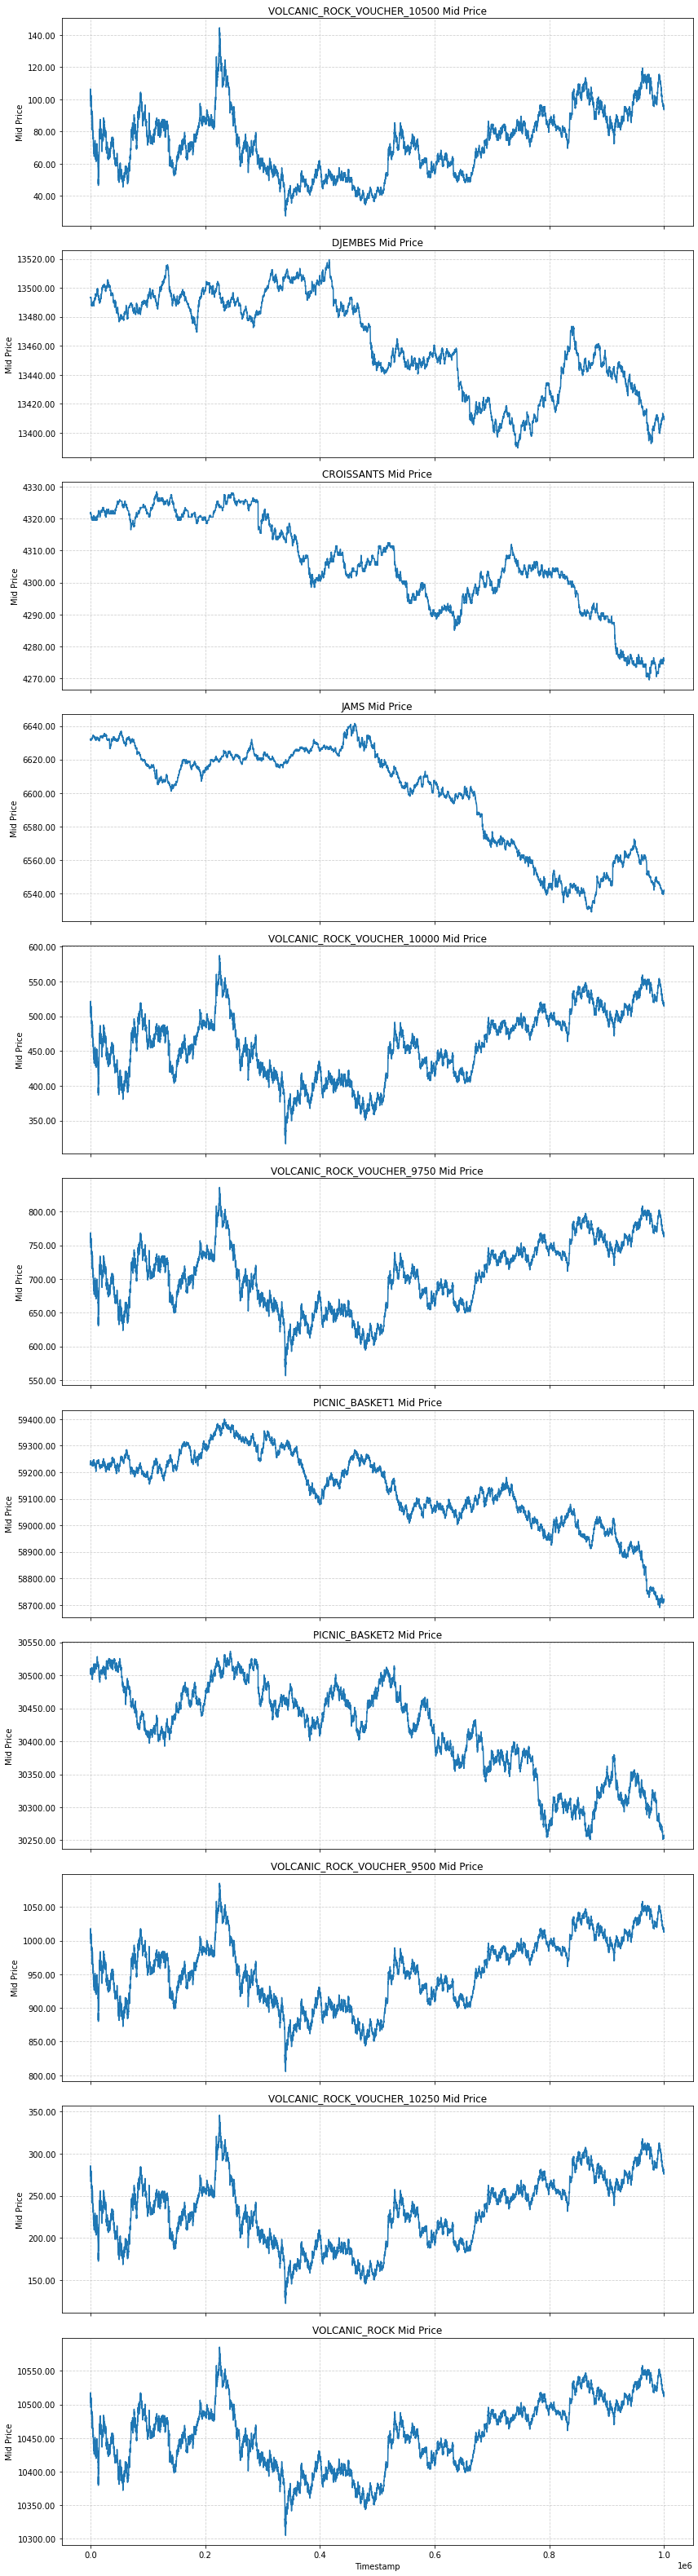

In [73]:
plot_product_mid_prices('data/2025/round3/prices_round_3_day_0.csv')

### Data Round 3 Day 1

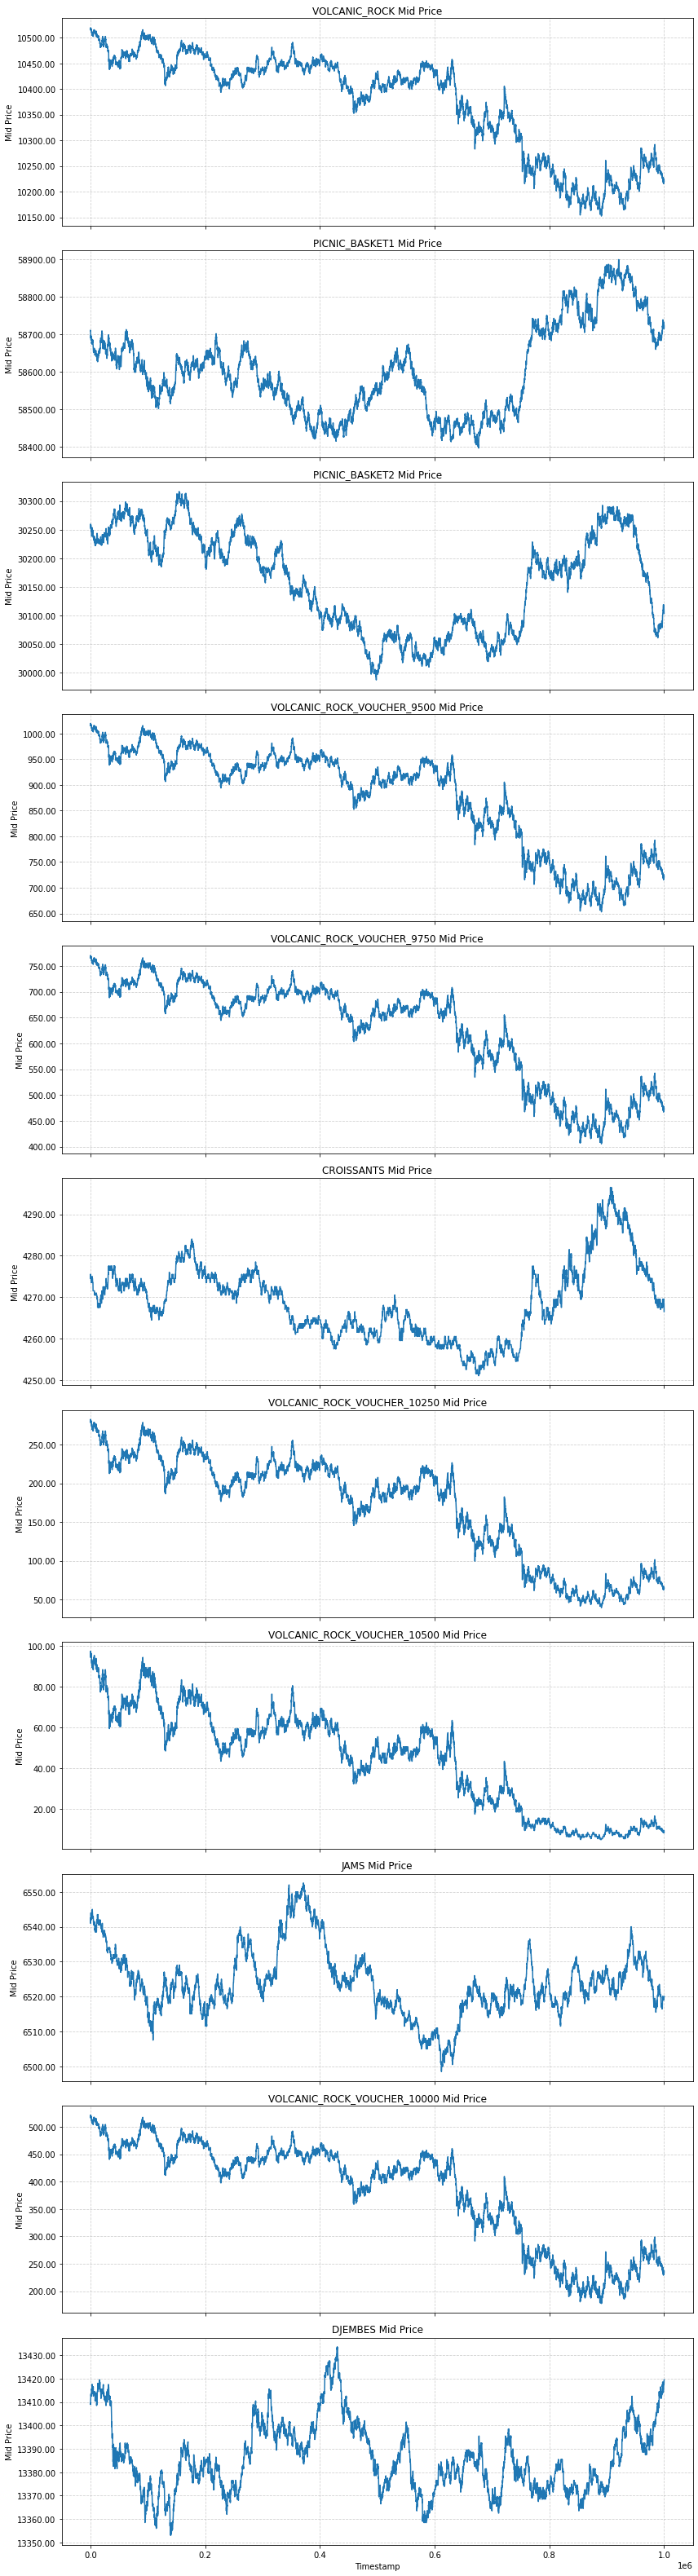

In [74]:
plot_product_mid_prices('data/2025/round3/prices_round_3_day_1.csv')

### Data Round 3 Day 2

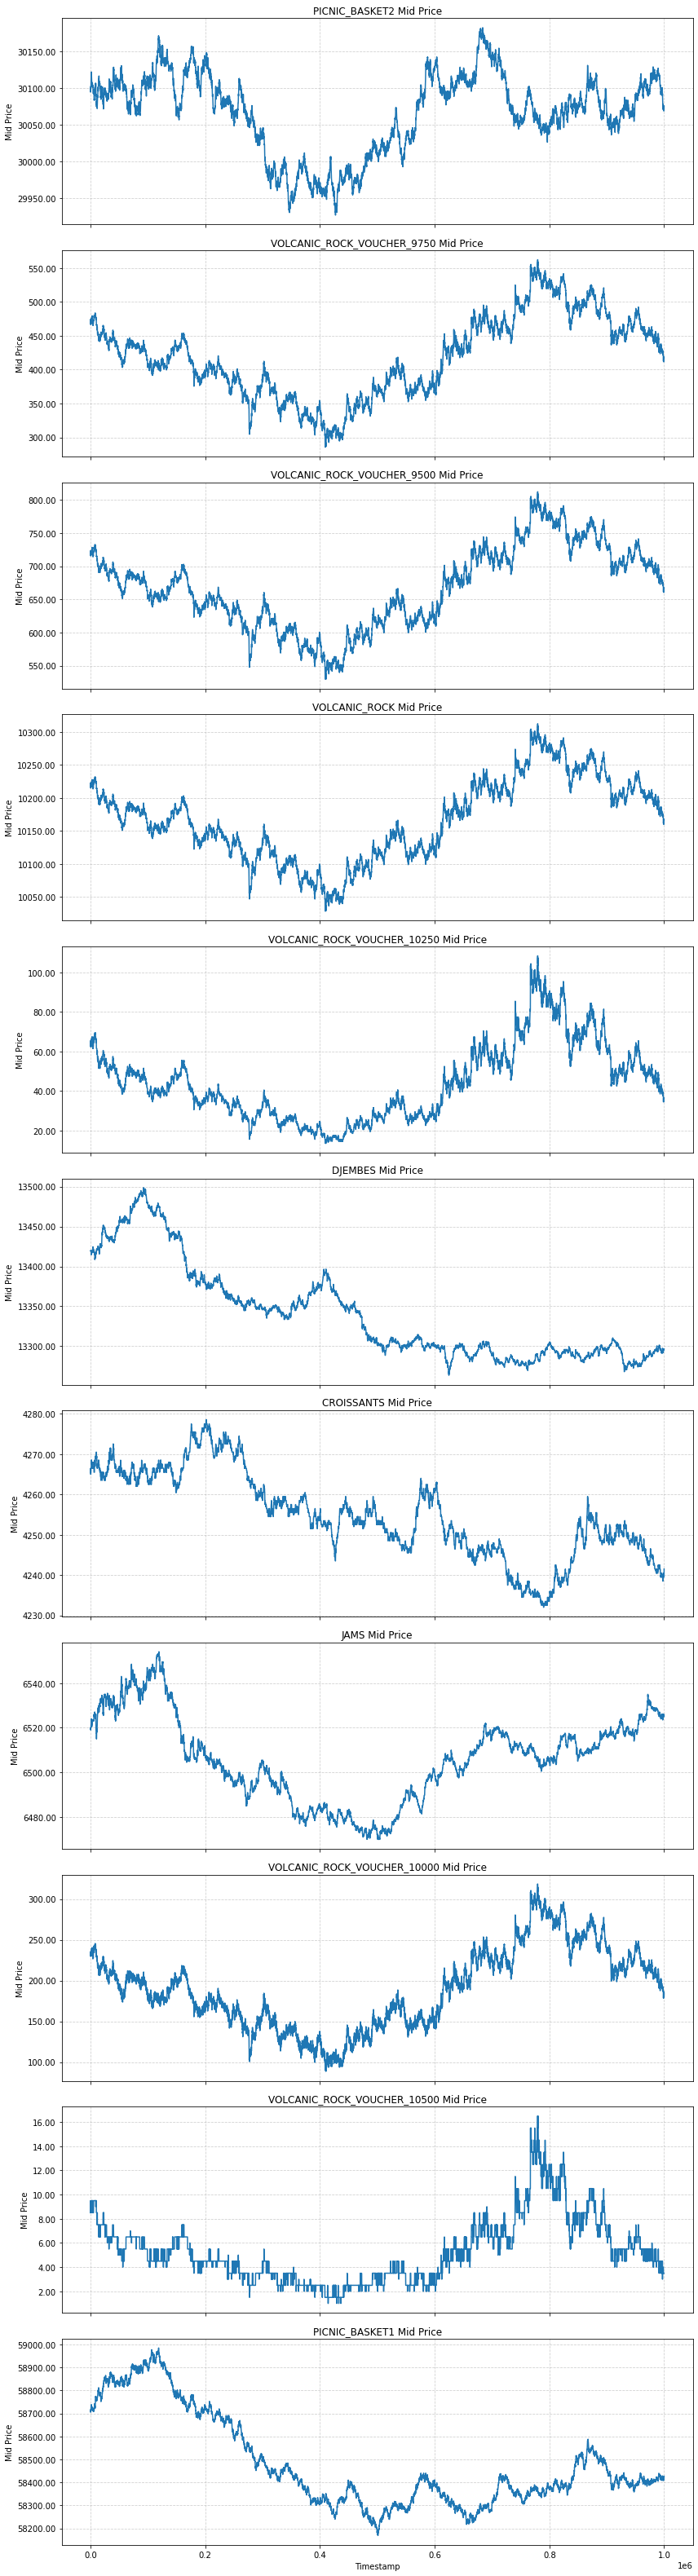

In [75]:
plot_product_mid_prices('data/2025/round3/prices_round_3_day_2.csv')

## Correlation Products 2025

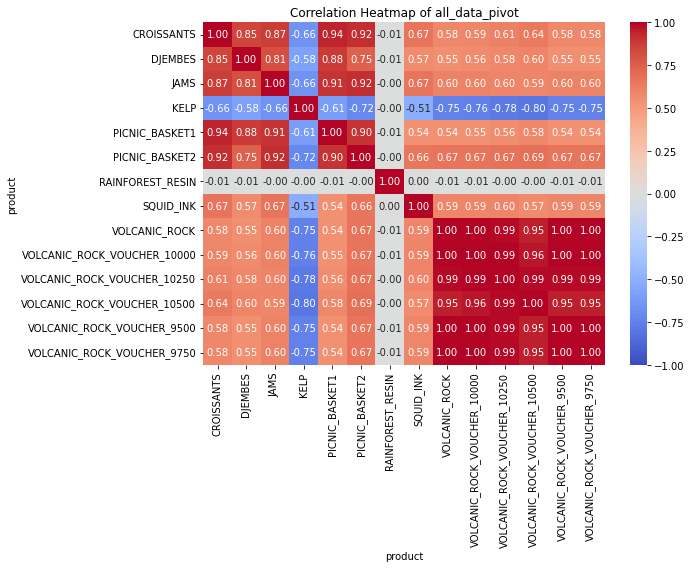

In [76]:
import seaborn as sns

df_day0 = pd.read_csv('data/2025/round3/prices_round_3_day_0.csv', sep=";")
df_day1 = pd.read_csv('data/2025/round3/prices_round_3_day_1.csv', sep=";")
df_day2 = pd.read_csv('data/2025/round3/prices_round_3_day_2.csv', sep=";")
# first merge the three dfs and then do the correlation
df = pd.concat([df_day0, df_day1, df_day2], ignore_index=True)

# Pivot to get products as columns and mid_price as values
pivot = df.pivot_table(index=["day", "timestamp"], columns="product", values="mid_price")

# Compute correlation matrix
corr_matrix = pivot.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of all_data_pivot")
plt.tight_layout()
plt.show()

## VOLCANIC products only

### Day 0 - midprices

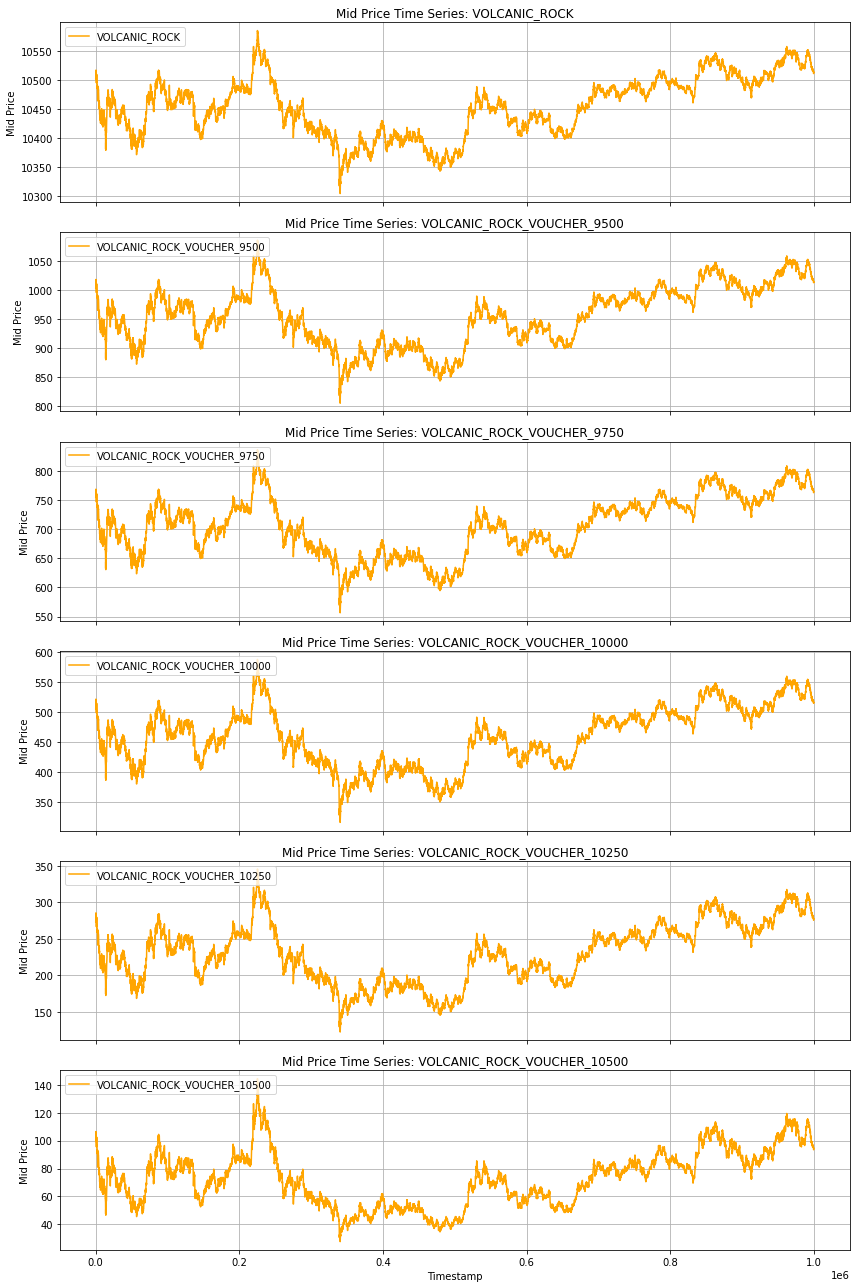

In [ ]:
plot_volcanic_products('data/2025/round3/prices_round_3_day_0.csv', volcanic_products)

### Day 1 - midprices

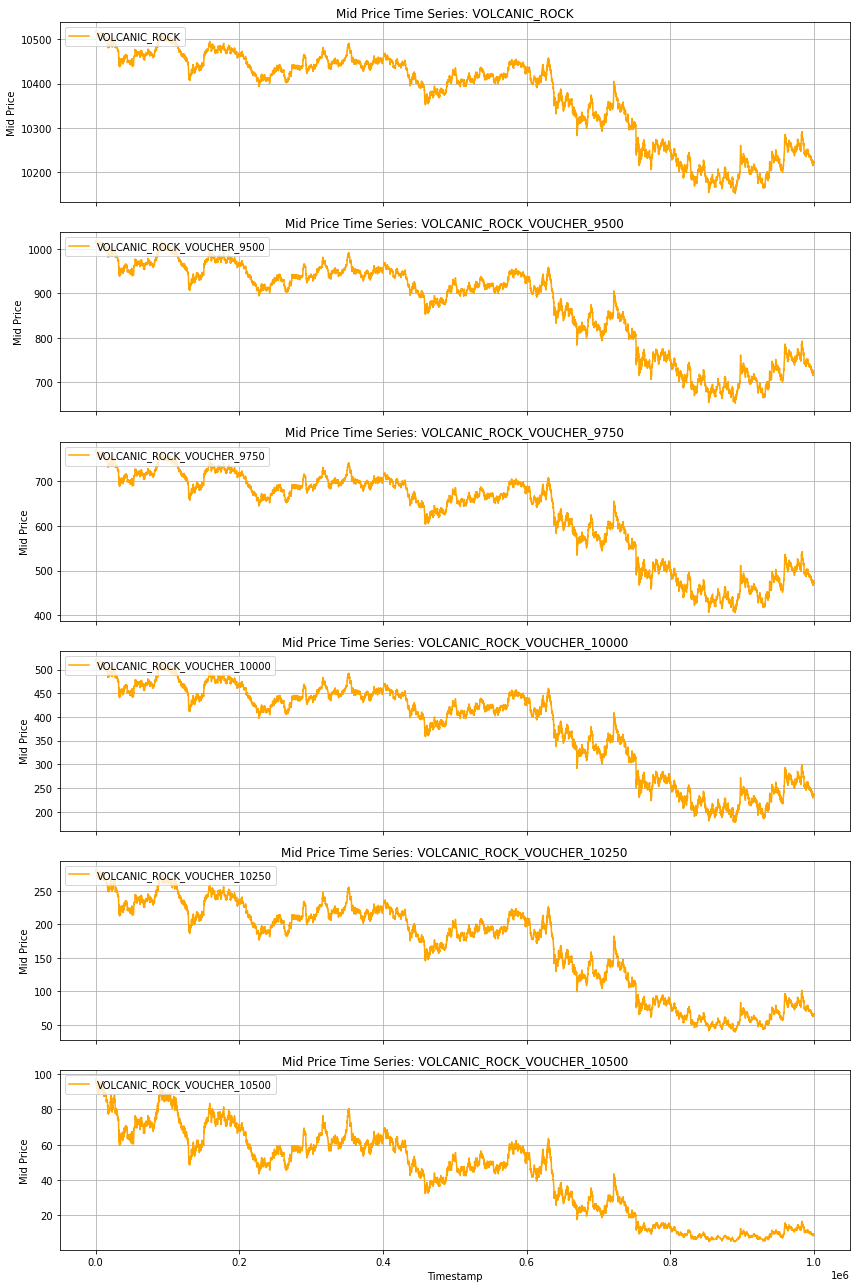

In [ ]:
plot_volcanic_products('data/2025/round3/prices_round_3_day_1.csv', volcanic_products)

### Day 2 - midprices

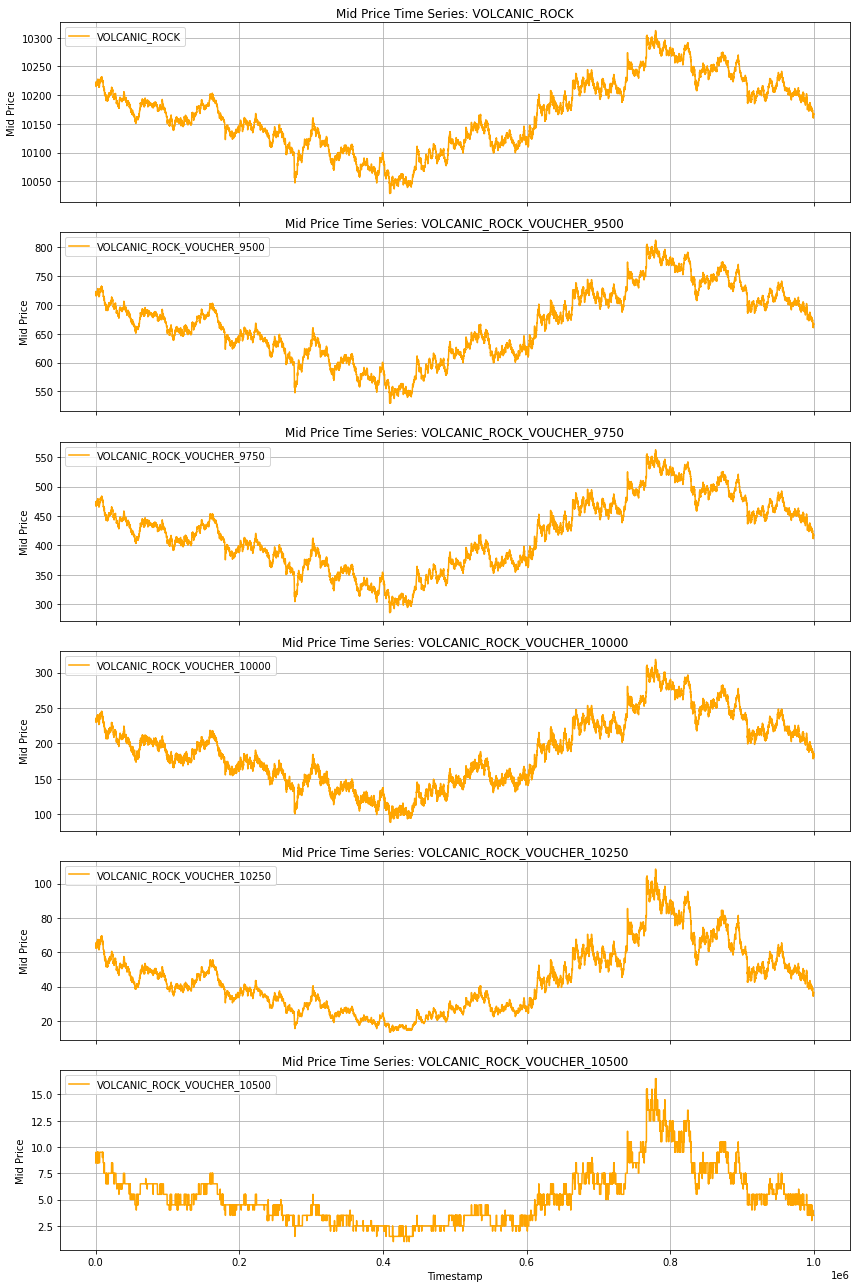

In [ ]:
plot_volcanic_products('data/2025/round3/prices_round_3_day_2.csv', volcanic_products)

## Plotting intrinsic values + mid prices Day 0, Day 1, Day 2

**Adding intrinsic values to the dataframes for plotting**

In [ ]:
df_day0 = pd.read_csv('data/2025/round3/prices_round_3_day_0.csv', sep=";")
df_day1 = pd.read_csv('data/2025/round3/prices_round_3_day_1.csv', sep=";")
df_day2 = pd.read_csv('data/2025/round3/prices_round_3_day_2.csv', sep=";")
df_day0_enriched = process_volcanic_day(df_day0)
df_day1_enriched = process_volcanic_day(df_day1)
df_day2_enriched = process_volcanic_day(df_day2)

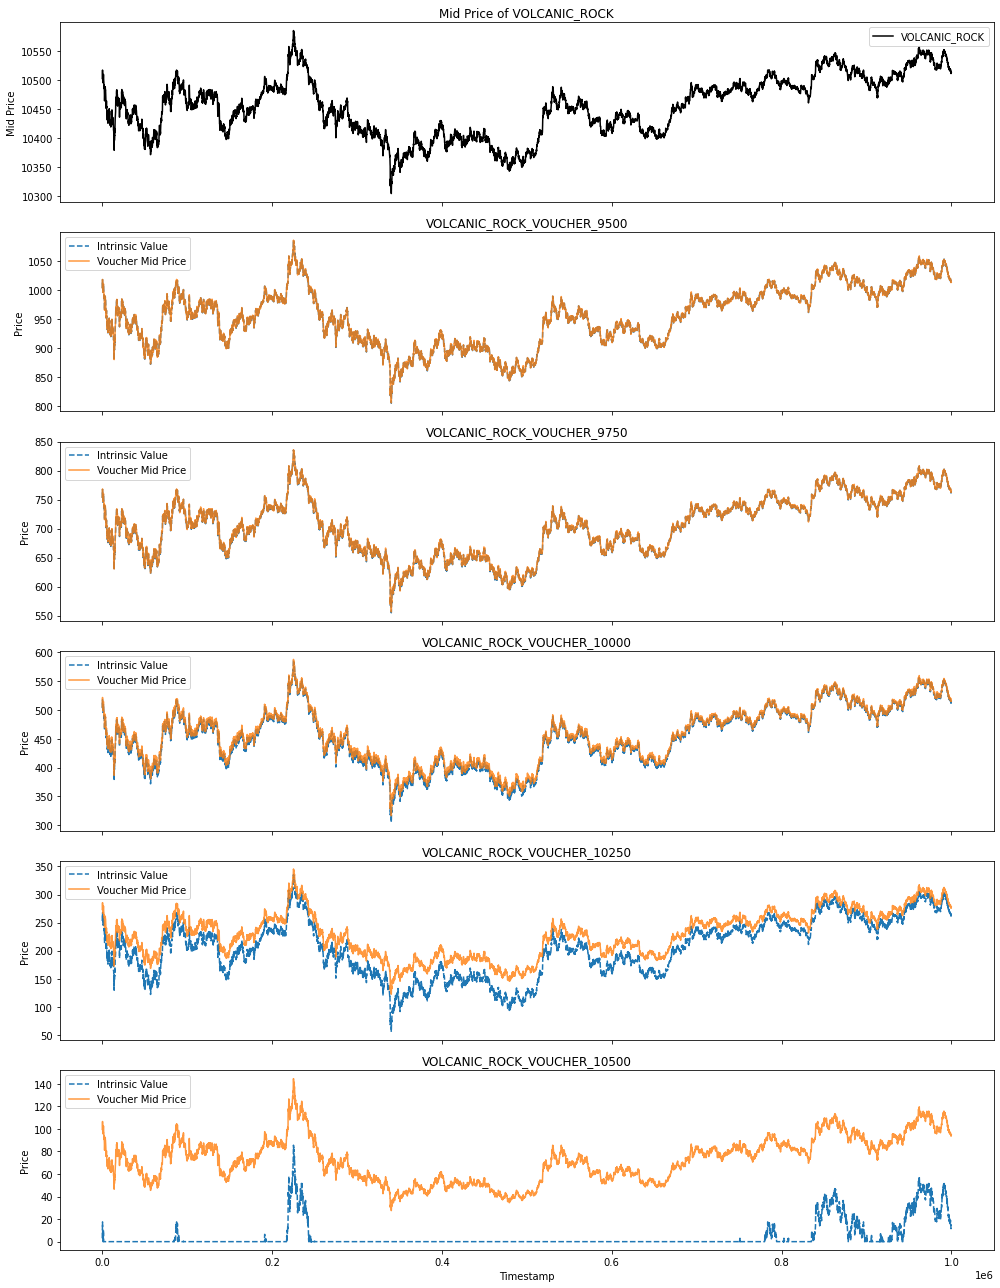

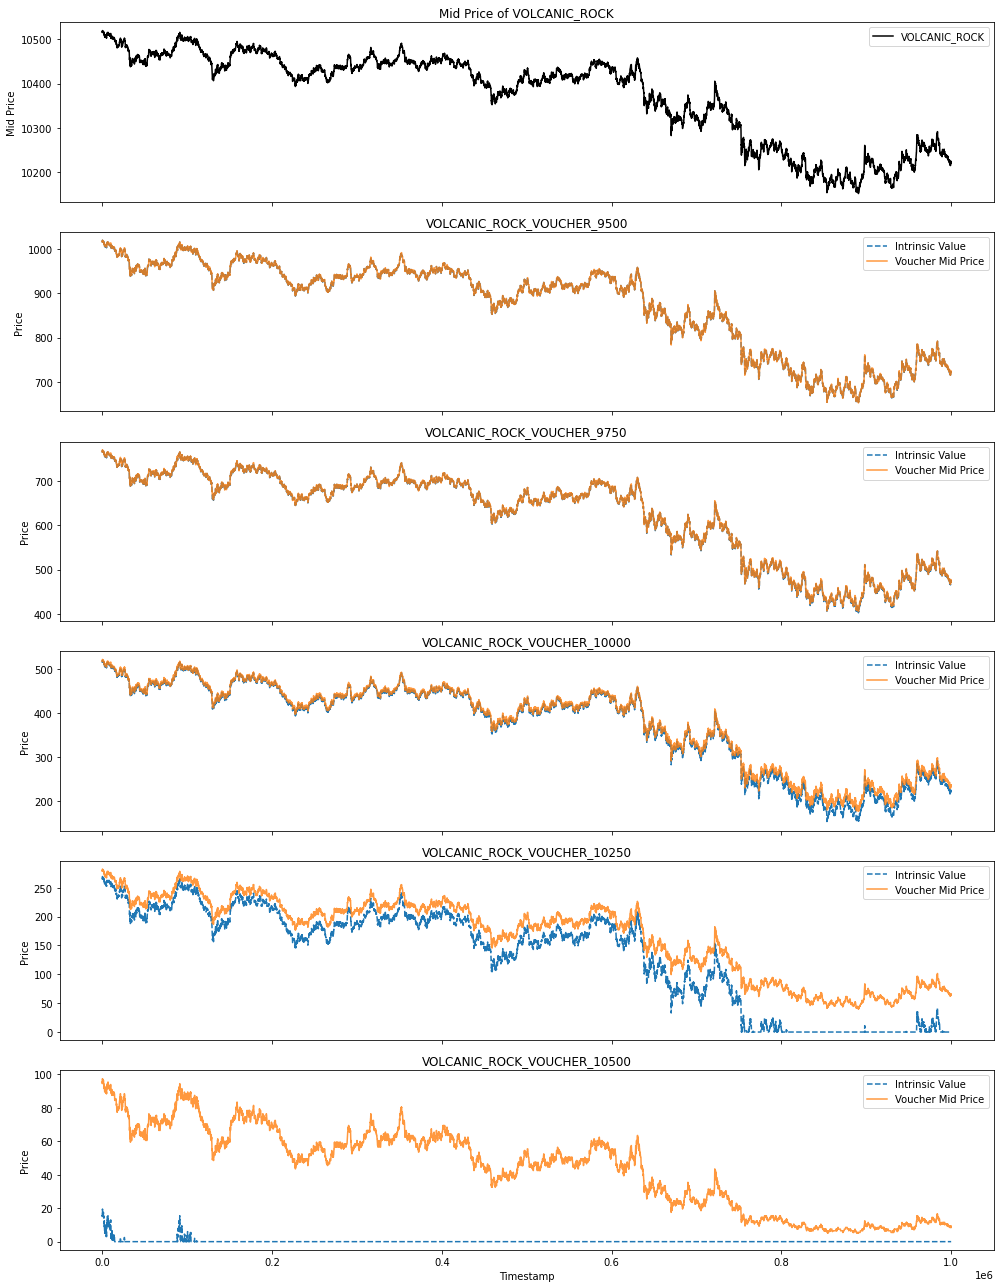

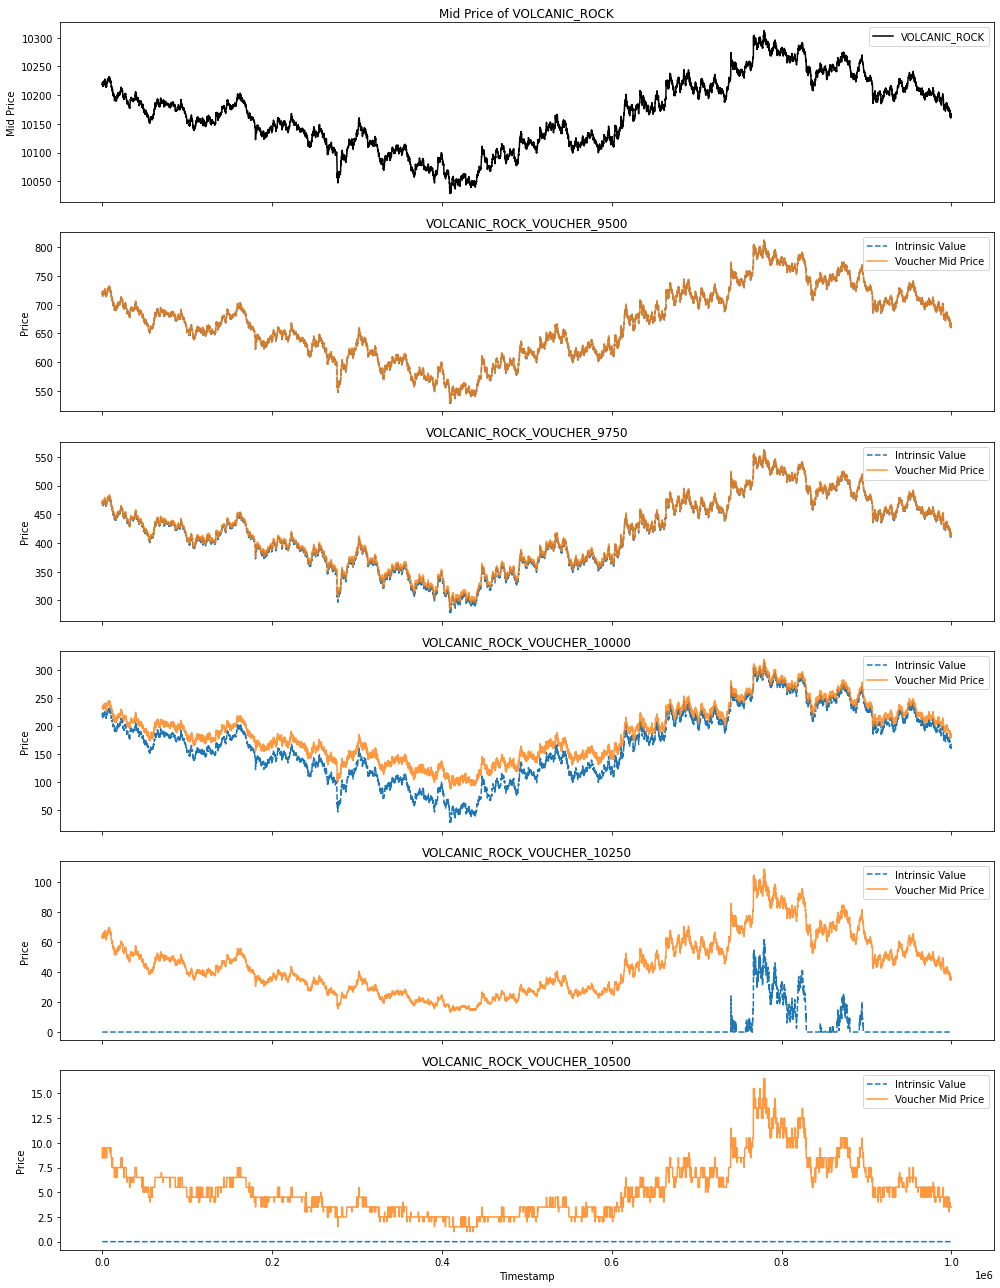

In [81]:
plot_rock_and_intrinsic_values(df_day0_enriched, voucher_names)
plot_rock_and_intrinsic_values(df_day1_enriched, voucher_names)
plot_rock_and_intrinsic_values(df_day2_enriched, voucher_names)

## Correlations 2023 (round4), 2025


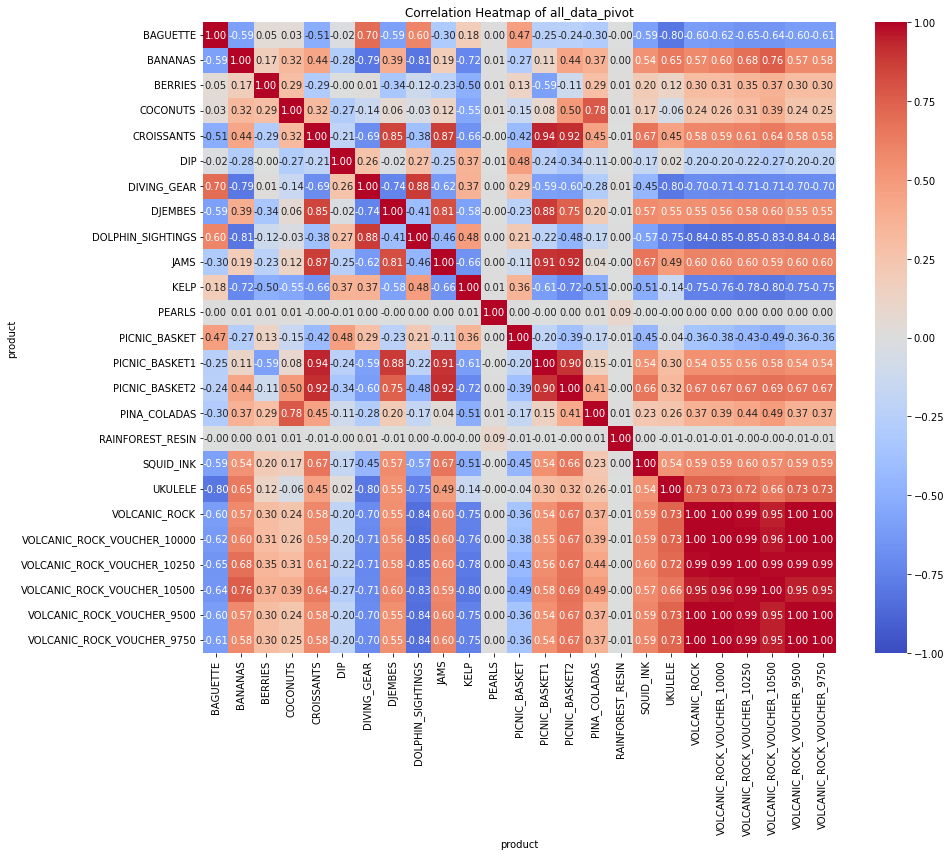

In [84]:
df1 = pd.read_csv('data/2025/round3/prices_round_3_day_0.csv', sep=";")
df2 = pd.read_csv('data/2025/round3/prices_round_3_day_1.csv', sep=";")
df3 = pd.read_csv('data/2025/round3/prices_round_3_day_2.csv', sep=";")
df4 = pd.read_csv('data/2023/island-data-bottle-round-4/prices_round_4_day_1.csv', sep=";")
df5 = pd.read_csv('data/2023/island-data-bottle-round-4/prices_round_4_day_2.csv', sep=";")
df6 = pd.read_csv('data/2023/island-data-bottle-round-4/prices_round_4_day_3.csv', sep=";")
df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)

pivot = df.pivot_table(index=["day", "timestamp"], columns="product", values="mid_price")
corr_matrix = pivot.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of all_data_pivot")
plt.tight_layout()
plt.show()

## Correlations 2024 (round3), 2025

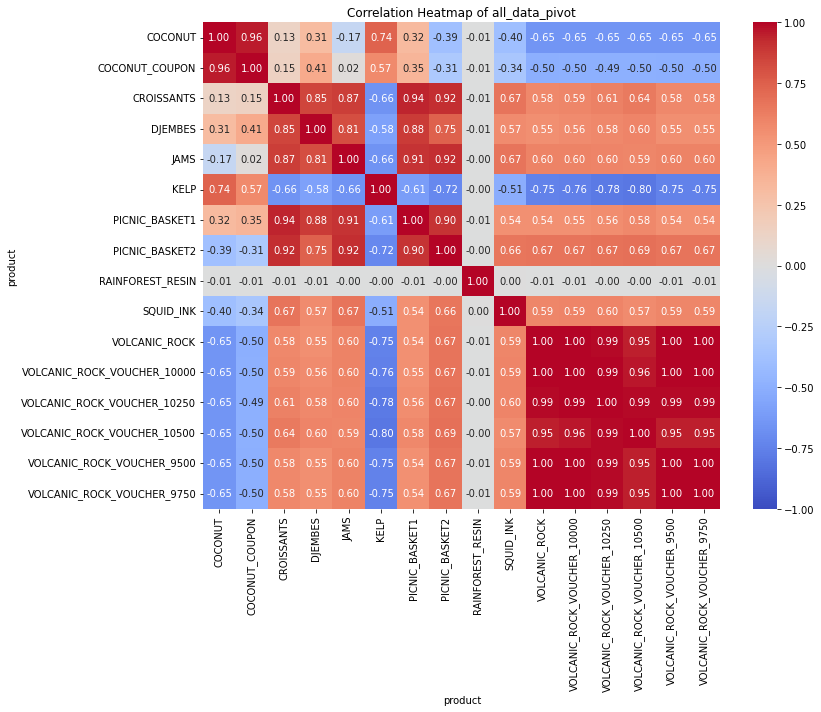

In [88]:
df1 = pd.read_csv('data/2025/round3/prices_round_3_day_0.csv', sep=";")
df2 = pd.read_csv('data/2025/round3/prices_round_3_day_1.csv', sep=";")
df3 = pd.read_csv('data/2025/round3/prices_round_3_day_2.csv', sep=";")
df7 = pd.read_csv('data/2024/round-4/prices_round_4_day_1.csv', sep=";")
df8 = pd.read_csv('data/2024/round-4/prices_round_4_day_2.csv', sep=";")
df9 = pd.read_csv('data/2024/round-4/prices_round_4_day_3.csv', sep=";")


df = pd.concat([df1, df2, df3, df7, df8, df9], ignore_index=True)

pivot = df.pivot_table(index=["day", "timestamp"], columns="product", values="mid_price")
corr_matrix = pivot.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of all_data_pivot")
plt.tight_layout()
plt.show()

I added the correlations above because I was curious to see which new and old products are highly correlated. Peeps in Discord keep saying how data is reused (and how the top 5 hardcoded their whole strat lmao) but anyway maybe it's best to ignore this and focus on the volcanic vouchers? 

Maybe we can try to come up with a strat for JAMS CROISSANTS and DJEMBES, since our round 2 algo did not trade those. Some users say they did pair trading with the 3 products, maybe something we could look into if there is time???

## Black-Scholes Formula

The code below is originally from a 2024 notebook to analyze the coconut coupon.   
I adapted it to work with the current products :-)  
What we do here is calculate the Black Scholes value for each voucher and plotting it against the midprice

Credits to https://github.com/Luka-R-Lukacevic/prosperity2/blob/main/round_04/research.ipynb



In [34]:
filename_1 = r'./data/2025/round3/prices_round_3_day_0.csv'
filename_2 = r'./data/2025/round3/prices_round_3_day_1.csv'
filename_3 = r'./data/2025/round3/prices_round_3_day_2.csv'

product_1 = "VOLCANIC_ROCK"
product_2 = "VOLCANIC_ROCK_VOUCHER_9500"
product_3 = "VOLCANIC_ROCK_VOUCHER_9750"
product_4 = "VOLCANIC_ROCK_VOUCHER_10000"
product_5 = "VOLCANIC_ROCK_VOUCHER_10250"
product_6 = "VOLCANIC_ROCK_VOUCHER_10500"


file_1 = pd.read_csv(filename_1, sep=';')  
file_1_coupon1 = file_1[file_1['product'] == product_2]
file_1_coupon2 = file_1[file_1['product'] == product_3]
file_1_coupon3 = file_1[file_1['product'] == product_4]
file_1_coupon4 = file_1[file_1['product'] == product_5]
file_1_coupon5 = file_1[file_1['product'] == product_6]
file_1 = file_1[file_1['product'] == product_1]

file_2 = pd.read_csv(filename_2, sep=';')  
file_2_coupon1 = file_2[file_2['product'] == product_2]
file_2_coupon2 = file_2[file_2['product'] == product_3]
file_2_coupon3 = file_2[file_2['product'] == product_4]
file_2_coupon4 = file_2[file_2['product'] == product_5]
file_2_coupon5 = file_2[file_2['product'] == product_6]
file_2 = file_2[file_2['product'] == product_1]

file_3 = pd.read_csv(filename_3, sep=';')  
file_3_coupon1 = file_3[file_3['product'] == product_2]
file_3_coupon2 = file_3[file_3['product'] == product_3]
file_3_coupon3 = file_3[file_3['product'] == product_4]
file_3_coupon4 = file_3[file_3['product'] == product_5]
file_3_coupon5 = file_3[file_3['product'] == product_6]
file_3 = file_3[file_3['product'] == product_1]


file_2['timestamp'] = file_2['timestamp'].apply(lambda x: x + 1000000)
file_3['timestamp'] = file_3['timestamp'].apply(lambda x: x + 2000000)

file_2_coupon1['timestamp'] = file_2_coupon1['timestamp'].apply(lambda x: x + 1000000)
file_2_coupon2['timestamp'] = file_2_coupon2['timestamp'].apply(lambda x: x + 1000000)
file_2_coupon3['timestamp'] = file_2_coupon3['timestamp'].apply(lambda x: x + 1000000)
file_2_coupon4['timestamp'] = file_2_coupon4['timestamp'].apply(lambda x: x + 1000000)
file_2_coupon5['timestamp'] = file_2_coupon5['timestamp'].apply(lambda x: x + 1000000)
file_3_coupon1['timestamp'] = file_3_coupon1['timestamp'].apply(lambda x: x + 2000000)
file_3_coupon2['timestamp'] = file_3_coupon2['timestamp'].apply(lambda x: x + 2000000)
file_3_coupon3['timestamp'] = file_3_coupon3['timestamp'].apply(lambda x: x + 2000000)
file_3_coupon4['timestamp'] = file_3_coupon4['timestamp'].apply(lambda x: x + 2000000)
file_3_coupon5['timestamp'] = file_3_coupon5['timestamp'].apply(lambda x: x + 2000000)


data = pd.concat([file_1, file_2, file_3])  ## Three days merged into 1 frame
data_coupon1 = pd.concat([file_1_coupon1, file_2_coupon1, file_3_coupon1]) # Merge coupon (voucher) data
data_coupon2 = pd.concat([file_1_coupon2, file_2_coupon2, file_3_coupon2])
data_coupon3 = pd.concat([file_1_coupon3, file_2_coupon3, file_3_coupon3])
data_coupon4 = pd.concat([file_1_coupon4, file_2_coupon4, file_3_coupon4])
data_coupon5 = pd.concat([file_1_coupon5, file_2_coupon5, file_3_coupon5])

df = pd.DataFrame()

mid_price_product_1 = data['mid_price'].reset_index().drop('index', axis=1)
mid_price_product_2 = data_coupon1['mid_price'].reset_index().drop('index', axis=1)
mid_price_product_3 = data_coupon2['mid_price'].reset_index().drop('index', axis=1)
mid_price_product_4 = data_coupon3['mid_price'].reset_index().drop('index', axis=1)
mid_price_product_5 = data_coupon4['mid_price'].reset_index().drop('index', axis=1)
mid_price_product_6 = data_coupon5['mid_price'].reset_index().drop('index', axis=1)

mid_price_product_1['log_return'] = np.log(mid_price_product_1['mid_price']) - np.log(mid_price_product_1['mid_price'].shift(1))
sigma = mid_price_product_1['log_return'].std() * np.sqrt(10000 * 252)  # annualized volatility
print("SIGMA: ", sigma)

SIGMA:  0.39733772549522567


In [ ]:
import math

def norm_cdf(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def black_scholes_call(S, X, T, r, sigma):
    d1 = (math.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    N_d1 = norm_cdf(d1)
    N_d2 = norm_cdf(d2)
    call_price = S * N_d1 - X * math.exp(-r * T) * N_d2
    return call_price, N_d1

r = 0.0  # No interest rate (in 2024 they also used 0.0)
T = 4 / 365  # DTE
'From WIKI: At beginning of Round 1, all the Vouchers have 7 trading days to expire. '
'By end of Round 5, vouchers will have 2 trading days left to expire.'
'--> We are in round 3 now, so 4 days left to expire'

In [27]:
mid_price_product_2['bs_value'] = np.nan # voucher 9500
mid_price_product_2['bs_delta'] = np.nan
mid_price_product_3['bs_value'] = np.nan # voucher 9750
mid_price_product_3['bs_delta'] = np.nan
mid_price_product_4['bs_value'] = np.nan # voucher 10000
mid_price_product_4['bs_delta'] = np.nan
mid_price_product_5['bs_value'] = np.nan # voucher 10250
mid_price_product_5['bs_delta'] = np.nan
mid_price_product_6['bs_value'] = np.nan # voucher 10500
mid_price_product_6['bs_delta'] = np.nan

3.939477454016052


<Axes: >

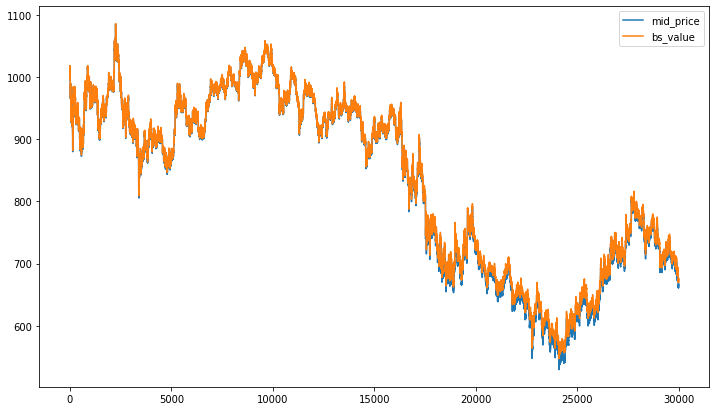

In [28]:
X = 9500  # Exercise price

for idx, price in enumerate(mid_price_product_1['mid_price']):
    mid_price_product_2['bs_value'].iloc[idx], mid_price_product_2['bs_delta'].iloc[idx] = black_scholes_call(price, X, T, r, sigma)
mid_price_product_2['price_diff'] = mid_price_product_2['mid_price'] - mid_price_product_2['bs_value']
print(mid_price_product_2['price_diff'].std())

mid_price_product_2[['mid_price', 'bs_value']].plot(figsize=[12, 7])
#mid_price_product_2[['bs_delta']].plot(figsize=[12, 7])

12.599919393329856


<Axes: >

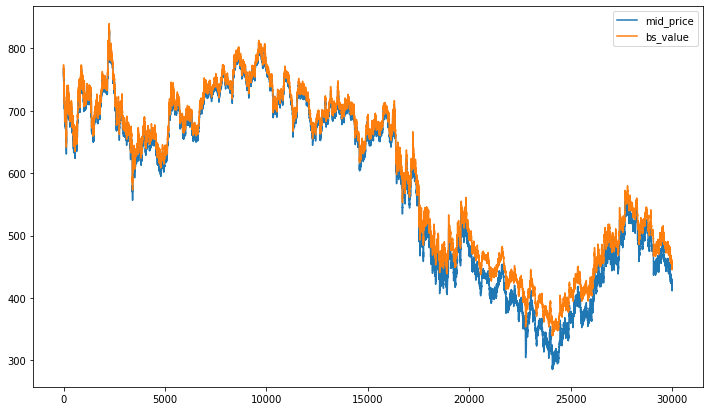

In [29]:
X = 9750  # Exercise price

for idx, price in enumerate(mid_price_product_1['mid_price']):
    mid_price_product_3['bs_value'].iloc[idx], mid_price_product_3['bs_delta'].iloc[idx] = black_scholes_call(price, X, T, r, sigma)
mid_price_product_3['price_diff'] = mid_price_product_3['mid_price'] - mid_price_product_3['bs_value']
print(mid_price_product_3['price_diff'].std())

mid_price_product_3[['mid_price', 'bs_value']].plot(figsize=[12, 7])
#mid_price_product_3[['bs_delta']].plot(figsize=[12, 7])

12.599919393329856


<Axes: >

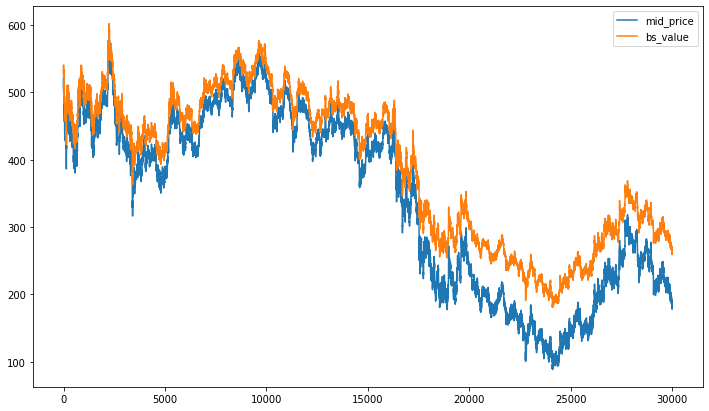

In [30]:
X = 10000  # Exercise price

for idx, price in enumerate(mid_price_product_1['mid_price']):
    mid_price_product_4['bs_value'].iloc[idx], mid_price_product_4['bs_delta'].iloc[idx] = black_scholes_call(price, X, T, r, sigma)
mid_price_product_4['price_diff'] = mid_price_product_4['mid_price'] - mid_price_product_4['bs_value']
print(mid_price_product_3['price_diff'].std())

mid_price_product_4[['mid_price', 'bs_value']].plot(figsize=[12, 7])
#mid_price_product_4[['bs_delta']].plot(figsize=[12, 7])

12.813832915870327


<Axes: >

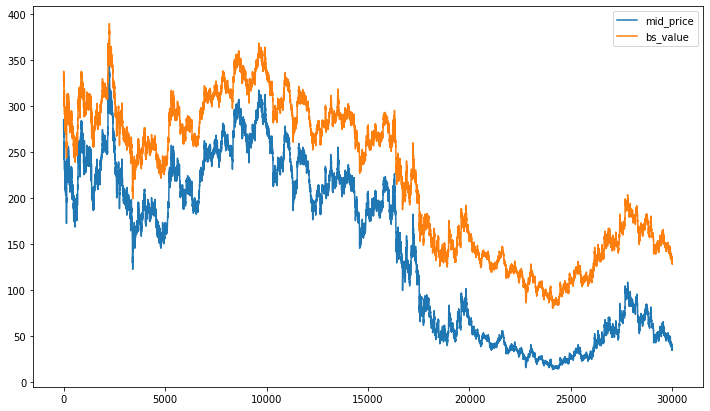

In [31]:
X = 10250  # Exercise price

for idx, price in enumerate(mid_price_product_1['mid_price']):
    mid_price_product_5['bs_value'].iloc[idx], mid_price_product_5['bs_delta'].iloc[idx] = black_scholes_call(price, X, T, r, sigma)
mid_price_product_5['price_diff'] = mid_price_product_5['mid_price'] - mid_price_product_5['bs_value']
print(mid_price_product_5['price_diff'].std())

mid_price_product_5[['mid_price', 'bs_value']].plot(figsize=[12, 7])
#mid_price_product_5[['bs_delta']].plot(figsize=[12, 7])

17.22436913225563


<Axes: >

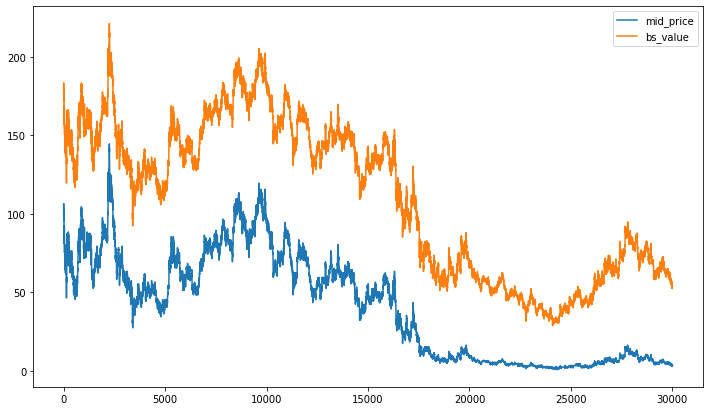

In [32]:
X = 10500  # Exercise price

for idx, price in enumerate(mid_price_product_1['mid_price']):
    mid_price_product_6['bs_value'].iloc[idx], mid_price_product_6['bs_delta'].iloc[idx] = black_scholes_call(price, X, T, r, sigma)
mid_price_product_6['price_diff'] = mid_price_product_6['mid_price'] - mid_price_product_6['bs_value']
print(mid_price_product_6['price_diff'].std())

mid_price_product_6[['mid_price', 'bs_value']].plot(figsize=[12, 7])
#mid_price_product_6[['bs_delta']].plot(figsize=[12, 7])

**How to use BS?**  
So this is what that a 2024 team did (https://github.com/davidteather/imc-prosperity-2024/blob/main/main.py):

In [ ]:
class BlackScholesStrategy(Strategy):
    def __init__(self, name: str, strike_price: float, maturity: int, max_pos: int):
        super().__init__(name, max_pos)
        self.strike_price = strike_price
        self.maturity = maturity  # days until expiration
        self.r = 0.0  # risk-free rate, assume 0 for simplicity
        self.sigma = 0.2  # initial volatility estimate, adjust as needed

    def update_volatility(self, historical_prices):
        # Use Exponentially Weighted Moving Average (EWMA) to update volatility
        lambda_ = 0.94  # Decay factor for EWMA, common choice in finance
        if len(historical_prices) > 1:
            returns = np.diff(historical_prices) / historical_prices[:-1]
            var = np.var(returns)
            if hasattr(self, 'sigma'):
                self.sigma = np.sqrt(lambda_ * self.sigma**2 + (1 - lambda_) * var) * np.sqrt(252)
            else:
                self.sigma = np.sqrt(var) * np.sqrt(252)

    def black_scholes_price(self, current_price, time_to_maturity, premium = 0):
        if current_price <= 0 or self.strike_price <= 0 or time_to_maturity <= 0 or self.sigma <= 0:
            return 0
        S = current_price
        K = self.strike_price
        T = time_to_maturity / 365
        r = self.r
        sigma = self.sigma
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        call_price = (S * cdf(d1) - (K + premium) * np.exp(-r * T) * cdf(d2))
        
        return call_price

    def trade(self, trading_state: TradingState, orders: list):
        current_price = self.get_current_price(trading_state, self.name.replace('_COUPON', ''))
        self.update_volatility(self.cached_prices)
        premium = self.calculate_dynamic_premium(self.maturity)  # Calculate premium dynamically
        theoretical_price = self.black_scholes_price(current_price, self.maturity, premium)
        order_depth = trading_state.order_depths[self.name]
        self.execute_trading_logic(order_depth, orders, theoretical_price, current_price)

    def calculate_dynamic_premium(self, days_until_expiration):
        # Dynamic premium calculation based on remaining days and volatility
        base_premium = 637.63  # Base premium, adjust as needed
        return base_premium
        return base_premium * (1 + self.sigma / 100) * (days_until_expiration / self.maturity)

    def execute_trading_logic(self, order_depth, orders, theoretical_price, current_price):
        # Sort the asks and bids so that we can access the best prices
        best_asks = sorted(order_depth.sell_orders.keys())
        best_bids = sorted(order_depth.buy_orders.keys(), reverse=True)

        # Go through the asks and determine if we should buy
        for i, ask_price in enumerate(best_asks):
            if ask_price < theoretical_price:
                self.buy_product(best_asks, i, order_depth, orders)

        # Go through the bids and determine if we should sell
        for i, bid_price in enumerate(best_bids):
            if bid_price > theoretical_price:
                self.sell_product(best_bids, i, order_depth, orders)

Alright so this strategy models the fair value of the coconutvoucher using the BS formula. It assumes the underlying asset is the mid-price of COCONUT.  

Vars:  
	•	Strike Price: 10000 (saw this in their main.py).  
	•	Maturity: Remaining days until expiry.  
	•	Risk-Free Rate: Assumed to be zero.  
	•	Volatility: Estimated dynamically using Exponentially Weighted Moving Average (EWMA) of historical returns.

Trading Logic:    
	1.	Update Volatility: Using past rock prices and EWMA. (In their main.py they also set a max log limit - 3750 - probably to make sure it doesn't become too large, cuz that slows down execution)  
	2.	Compute Theoretical Price: Via the BS formula.  
	3.	Buy the coupon if its ask price is below the theoretical price.  
	4.	Sell the coupon if its bid price is above the theoretical price.  

The strategy assumes a mispricing opportunity exists between the market price and theoretical value of the coupon.

Think this is a decent strategy to use.  
Here is another example we could look at: https://github.com/Luka-R-Lukacevic/prosperity2/blob/main/round_04/round_04_jannik.py